In [2]:
import duckdb
import pandas as pd
from IPython.display import Markdown, display
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np



In [3]:
con = duckdb.connect()
con.execute(f"INSTALL sqlite")
con.execute(f"LOAD sqlite")
con.execute(f"SET GLOBAL sqlite_all_varchar=true")
con.execute(f"CALL sqlite_attach('data/database.sqlite')")

In [107]:
tables=con.query(
            f"""--sql
SELECT table_name as 'Table Name', COUNT(column_name) AS 'Column Count' FROM information_schema.columns GROUP BY table_name
"""
        ).to_df()

| Table Name        |   Column Count |
|:------------------|---------------:|
| sqlite_sequence   |              2 |
| Player_Attributes |             42 |
| Player            |              7 |
| Match             |            115 |
| League            |              3 |
| Country           |              2 |
| Team              |              5 |
| Team_Attributes   |             25 |

In [108]:
table_columns = con.query(
    f"""--sql
SELECT table_name,
    GROUP_CONCAT(column_name) AS column_names
FROM information_schema.columns
GROUP BY table_name"""
).to_df()
tables['column_names']=table_columns['column_names'].apply(lambda x: x.split(','))

In [135]:
row_counts={}
for table_name in tables['Table Name']:
    row_counts[table_name]=con.query(f"""--sql
                                     SELECT COUNT(*) FROM {table_name}
                                     """).fetchone()[0]
    

tables=tables.join(pd.Series(row_counts).rename('Row Count'), on='Table Name')

,Table Name,Column Count,column_names,Row Count
0,sqlite_sequence,2,"[name, seq]",7
1,Player_Attributes,42,"[id, player_fifa_api_id, player_api_id, date, ...",183978
2,Player,7,"[id, player_api_id, player_name, player_fifa_a...",11060
3,Match,115,"[id, country_id, league_id, season, stage, dat...",25979
4,League,3,"[id, country_id, name]",11
5,Country,2,"[id, name]",11
6,Team,5,"[id, team_api_id, team_fifa_api_id, team_long_...",299
7,Team_Attributes,25,"[id, team_fifa_api_id, team_api_id, date, buil...",1458


In [136]:
Markdown(tabulate(
tables[['Table Name','Column Count','Row Count']]
, showindex=False, headers="keys", tablefmt="pipe"))

| Table Name        |   Column Count |   Row Count |
|:------------------|---------------:|------------:|
| sqlite_sequence   |              2 |           7 |
| Player_Attributes |             42 |      183978 |
| Player            |              7 |       11060 |
| Match             |            115 |       25979 |
| League            |              3 |          11 |
| Country           |              2 |          11 |
| Team              |              5 |         299 |
| Team_Attributes   |             25 |        1458 |

In [105]:
con.query("""--sql
SELECT *
FROM information_schema.tables
GROUP BY table_name
""")

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,memory,main,sqlite_sequence,VIEW,NaN,NaN,NaN,NaN,NaN,NO,NO,NaN
1,memory,main,Player_Attributes,VIEW,NaN,NaN,NaN,NaN,NaN,NO,NO,NaN
2,memory,main,Player,VIEW,NaN,NaN,NaN,NaN,NaN,NO,NO,NaN
3,memory,main,Match,VIEW,NaN,NaN,NaN,NaN,NaN,NO,NO,NaN
4,memory,main,League,VIEW,NaN,NaN,NaN,NaN,NaN,NO,NO,NaN
5,memory,main,Country,VIEW,NaN,NaN,NaN,NaN,NaN,NO,NO,NaN
6,memory,main,Team,VIEW,NaN,NaN,NaN,NaN,NaN,NO,NO,NaN
7,memory,main,Team_Attributes,VIEW,NaN,NaN,NaN,NaN,NaN,NO,NO,NaN


In [99]:
Markdown(tabulate(
con.query(
            """--sql
SELECT table_name as 'Table Name', COUNT(column_name) AS 'Column Count' FROM information_schema.columns GROUP BY table_name
"""
        ).to_df()
, showindex=False, headers="keys", tablefmt="pipe"))

| Table Name        |   Column Count |
|:------------------|---------------:|
| sqlite_sequence   |              2 |
| Player_Attributes |             42 |
| Player            |              7 |
| Match             |            115 |
| League            |              3 |
| Country           |              2 |
| Team              |              5 |
| Team_Attributes   |             25 |

In [6]:
# tables_writer=pd.ExcelWriter('tables.xlsx')
# for i, tab in enumerate(tables.explode('column_names').groupby('table_name')):
#     df_to_write=tab[1]
#     df_to_write.rename(columns={'column_names':tab[0]},inplace=True)
#     df_to_write.to_excel(tables_writer,columns=[tab[0]],startcol=i,index=False)
# tables_writer.close()

In [ ]:
con.query(
    """--sql
SELECT count(distinct player_api_id) FROM Player"""
).fetchone()[0]

### Player attributes

#### How many players are in the player table?

In [12]:
con.query(
    """--sql
SELECT count(distinct player_api_id) FROM Player"""
).fetchone()[0]

11060

#### How many entries are in the player attributes table?

In [13]:
con.query(
    """--sql
SELECT count(player_api_id) from Player_Attributes WHERE player_api_id IN (SELECT player_api_id FROM Player)"""
).fetchone()[0]

183978

#### How many different entries can a player have?

In [19]:
con.query(
    f"""--sql
SELECT MAX(num_entries) as "Max entries",
    MIN(num_entries) as "Min entries"
FROM(
        SELECT player_api_id,
            count(player_api_id) as num_entries
        FROM Player_Attributes
        GROUP BY player_api_id
    )
    """
).to_df()

,Max entries,Min entries
0,56,2


In [72]:
con.query(
    """--sql
    SELECT *
    FROM Player
    WHERE player_api_id = (SELECT DISTINCT player_api_id FROM Player_Attributes WHERE overall_rating = (SELECT MAX(overall_rating) FROM Player_Attributes))"""
).to_df()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,6176,30981,Lionel Messi,158023,1987-06-24 00:00:00,170.18,159


array([[<Axes: title={'center': 'overall_rating'}>,
        <Axes: title={'center': 'potential'}>]], dtype=object)

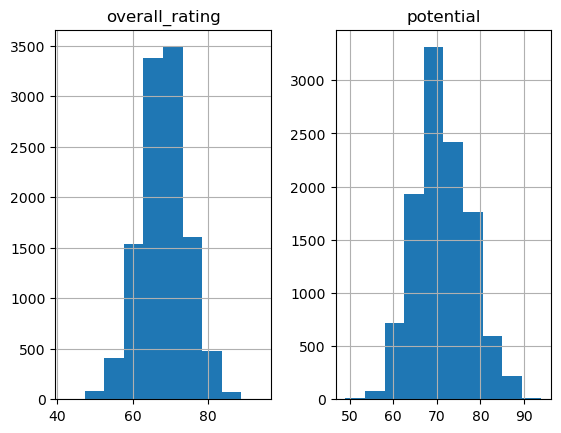

In [82]:
rating_potential=con.query(
    """--sql
    SELECT overall_rating, potential
    FROM Player_Attributes p
    JOIN(
    SELECT player_api_id, MAX(date) AS max_date FROM Player_attributes GROUP BY player_api_id) sub 
    ON p.player_api_id=sub.player_api_id AND p.date=sub.max_date"""
).to_df()
rating_potential.dropna(inplace=True)
rating_potential=rating_potential.astype(int)
rating_potential.hist()

In [10]:
Markdown(tabulate(con.query(
    """--sql
SELECT * from Player_Attributes LIMIT 5"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|   id |   player_fifa_api_id |   player_api_id | date                |   overall_rating |   potential | preferred_foot   | attacking_work_rate   | defensive_work_rate   |   crossing |   finishing |   heading_accuracy |   short_passing |   volleys |   dribbling |   curve |   free_kick_accuracy |   long_passing |   ball_control |   acceleration |   sprint_speed |   agility |   reactions |   balance |   shot_power |   jumping |   stamina |   strength |   long_shots |   aggression |   interceptions |   positioning |   vision |   penalties |   marking |   standing_tackle |   sliding_tackle |   gk_diving |   gk_handling |   gk_kicking |   gk_positioning |   gk_reflexes |
|-----:|---------------------:|----------------:|:--------------------|-----------------:|------------:|:-----------------|:----------------------|:----------------------|-----------:|------------:|-------------------:|----------------:|----------:|------------:|--------:|---------------------:|---------------:|---------------:|---------------:|---------------:|----------:|------------:|----------:|-------------:|----------:|----------:|-----------:|-------------:|-------------:|----------------:|--------------:|---------:|------------:|----------:|------------------:|-----------------:|------------:|--------------:|-------------:|-----------------:|--------------:|
|    1 |               218353 |          505942 | 2016-02-18 00:00:00 |               67 |          71 | right            | medium                | medium                |         49 |          44 |                 71 |              61 |        44 |          51 |      45 |                   39 |             64 |             49 |             60 |             64 |        59 |          47 |        65 |           55 |        58 |        54 |         76 |           35 |           71 |              70 |            45 |       54 |          48 |        65 |                69 |               69 |           6 |            11 |           10 |                8 |             8 |
|    2 |               218353 |          505942 | 2015-11-19 00:00:00 |               67 |          71 | right            | medium                | medium                |         49 |          44 |                 71 |              61 |        44 |          51 |      45 |                   39 |             64 |             49 |             60 |             64 |        59 |          47 |        65 |           55 |        58 |        54 |         76 |           35 |           71 |              70 |            45 |       54 |          48 |        65 |                69 |               69 |           6 |            11 |           10 |                8 |             8 |
|    3 |               218353 |          505942 | 2015-09-21 00:00:00 |               62 |          66 | right            | medium                | medium                |         49 |          44 |                 71 |              61 |        44 |          51 |      45 |                   39 |             64 |             49 |             60 |             64 |        59 |          47 |        65 |           55 |        58 |        54 |         76 |           35 |           63 |              41 |            45 |       54 |          48 |        65 |                66 |               69 |           6 |            11 |           10 |                8 |             8 |
|    4 |               218353 |          505942 | 2015-03-20 00:00:00 |               61 |          65 | right            | medium                | medium                |         48 |          43 |                 70 |              60 |        43 |          50 |      44 |                   38 |             63 |             48 |             60 |             64 |        59 |          46 |        65 |           54 |        58 |        54 |         76 |           34 |           62 |              40 |            44 |       53 |          47 |        62 |                63 |               66 |           5 |            10 |            9 |                7 |             7 |
|    5 |               218353 |          505942 | 2007-02-22 00:00:00 |               61 |          65 | right            | medium                | medium                |         48 |          43 |                 70 |              60 |        43 |          50 |      44 |                   38 |             63 |             48 |             60 |             64 |        59 |          46 |        65 |           54 |        58 |        54 |         76 |           34 |           62 |              40 |            44 |       53 |          47 |        62 |                63 |               66 |           5 |            10 |            9 |                7 |             7 |

In [54]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT * from Player LIMIT 5"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|   id |   player_api_id | player_name        |   player_fifa_api_id | birthday            |   height |   weight |
|-----:|----------------:|:-------------------|---------------------:|:--------------------|---------:|---------:|
|    1 |          505942 | Aaron Appindangoye |               218353 | 1992-02-29 00:00:00 |   182.88 |      187 |
|    2 |          155782 | Aaron Cresswell    |               189615 | 1989-12-15 00:00:00 |   170.18 |      146 |
|    3 |          162549 | Aaron Doran        |               186170 | 1991-05-13 00:00:00 |   170.18 |      163 |
|    4 |           30572 | Aaron Galindo      |               140161 | 1982-05-08 00:00:00 |   182.88 |      198 |
|    5 |           23780 | Aaron Hughes       |                17725 | 1979-11-08 00:00:00 |   182.88 |      154 |

### Teams

In [86]:
con.query(
    f"""--sql
SELECT count(*) from Team"""
).to_df()

,count_star()
0,299


In [88]:
con.query(
    f"""--sql
SELECT count(distinct team_api_id) from Team_Attributes"""
).to_df()

,count(DISTINCT team_api_id)
0,288


In [83]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT * from Team LIMIT 5"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|   id |   team_api_id |   team_fifa_api_id | team_long_name    | team_short_name   |
|-----:|--------------:|-------------------:|:------------------|:------------------|
|    1 |          9987 |                673 | KRC Genk          | GEN               |
|    2 |          9993 |                675 | Beerschot AC      | BAC               |
|    3 |         10000 |              15005 | SV Zulte-Waregem  | ZUL               |
|    4 |          9994 |               2007 | Sporting Lokeren  | LOK               |
|    5 |          9984 |               1750 | KSV Cercle Brugge | CEB               |

In [84]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT * from Team_Attributes LIMIT 5"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|   id |   team_fifa_api_id |   team_api_id | date                |   buildUpPlaySpeed | buildUpPlaySpeedClass   |   buildUpPlayDribbling | buildUpPlayDribblingClass   |   buildUpPlayPassing | buildUpPlayPassingClass   | buildUpPlayPositioningClass   |   chanceCreationPassing | chanceCreationPassingClass   |   chanceCreationCrossing | chanceCreationCrossingClass   |   chanceCreationShooting | chanceCreationShootingClass   | chanceCreationPositioningClass   |   defencePressure | defencePressureClass   |   defenceAggression | defenceAggressionClass   |   defenceTeamWidth | defenceTeamWidthClass   | defenceDefenderLineClass   |
|-----:|-------------------:|--------------:|:--------------------|-------------------:|:------------------------|-----------------------:|:----------------------------|---------------------:|:--------------------------|:------------------------------|------------------------:|:-----------------------------|-------------------------:|:------------------------------|-------------------------:|:------------------------------|:---------------------------------|------------------:|:-----------------------|--------------------:|:-------------------------|-------------------:|:------------------------|:---------------------------|
|    1 |                434 |          9930 | 2010-02-22 00:00:00 |                 60 | Balanced                |                    nan | Little                      |                   50 | Mixed                     | Organised                     |                      60 | Normal                       |                       65 | Normal                        |                       55 | Normal                        | Organised                        |                50 | Medium                 |                  55 | Press                    |                 45 | Normal                  | Cover                      |
|    2 |                434 |          9930 | 2014-09-19 00:00:00 |                 52 | Balanced                |                     48 | Normal                      |                   56 | Mixed                     | Organised                     |                      54 | Normal                       |                       63 | Normal                        |                       64 | Normal                        | Organised                        |                47 | Medium                 |                  44 | Press                    |                 54 | Normal                  | Cover                      |
|    3 |                434 |          9930 | 2015-09-10 00:00:00 |                 47 | Balanced                |                     41 | Normal                      |                   54 | Mixed                     | Organised                     |                      54 | Normal                       |                       63 | Normal                        |                       64 | Normal                        | Organised                        |                47 | Medium                 |                  44 | Press                    |                 54 | Normal                  | Cover                      |
|    4 |                 77 |          8485 | 2010-02-22 00:00:00 |                 70 | Fast                    |                    nan | Little                      |                   70 | Long                      | Organised                     |                      70 | Risky                        |                       70 | Lots                          |                       70 | Lots                          | Organised                        |                60 | Medium                 |                  70 | Double                   |                 70 | Wide                    | Cover                      |
|    5 |                 77 |          8485 | 2011-02-22 00:00:00 |                 47 | Balanced                |                    nan | Little                      |                   52 | Mixed                     | Organised                     |                      53 | Normal                       |                       48 | Normal                        |                       52 | Normal                        | Organised                        |                47 | Medium                 |                  47 | Press                    |                 52 | Normal                  | Cover                      |

In [97]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT * from Match LIMIT 5"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|   id |   country_id |   league_id | season    |   stage | date                |   match_api_id |   home_team_api_id |   away_team_api_id |   home_team_goal |   away_team_goal |   home_player_X1 |   home_player_X2 |   home_player_X3 |   home_player_X4 |   home_player_X5 |   home_player_X6 |   home_player_X7 |   home_player_X8 |   home_player_X9 |   home_player_X10 |   home_player_X11 |   away_player_X1 |   away_player_X2 |   away_player_X3 |   away_player_X4 |   away_player_X5 |   away_player_X6 |   away_player_X7 |   away_player_X8 |   away_player_X9 |   away_player_X10 |   away_player_X11 |   home_player_Y1 |   home_player_Y2 |   home_player_Y3 |   home_player_Y4 |   home_player_Y5 |   home_player_Y6 |   home_player_Y7 |   home_player_Y8 |   home_player_Y9 |   home_player_Y10 |   home_player_Y11 |   away_player_Y1 |   away_player_Y2 |   away_player_Y3 |   away_player_Y4 |   away_player_Y5 |   away_player_Y6 |   away_player_Y7 |   away_player_Y8 |   away_player_Y9 |   away_player_Y10 |   away_player_Y11 |   home_player_1 |   home_player_2 |   home_player_3 |   home_player_4 |   home_player_5 |   home_player_6 |   home_player_7 |   home_player_8 |   home_player_9 |   home_player_10 |   home_player_11 |   away_player_1 |   away_player_2 |   away_player_3 |   away_player_4 |   away_player_5 |   away_player_6 |   away_player_7 |   away_player_8 |   away_player_9 |   away_player_10 |   away_player_11 |   goal |   shoton |   shotoff |   foulcommit |   card |   cross |   corner |   possession |   B365H |   B365D |   B365A |   BWH |   BWD |   BWA |   IWH |   IWD |   IWA |   LBH |   LBD |   LBA |   PSH |   PSD |   PSA |   WHH |   WHD |   WHA |   SJH |   SJD |   SJA |   VCH |   VCD |   VCA |   GBH |   GBD |   GBA |   BSH |   BSD |   BSA |
|-----:|-------------:|------------:|:----------|--------:|:--------------------|---------------:|-------------------:|-------------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|------------------:|------------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|------------------:|------------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|------------------:|------------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|-----------------:|-----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|-----------------:|-----------------:|-------:|---------:|----------:|-------------:|-------:|--------:|---------:|-------------:|--------:|--------:|--------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|
|    1 |            1 |           1 | 2008/2009 |       1 | 2008-08-17 00:00:00 |         492473 |               9987 |               9993 |                1 |                1 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    1.73 |    3.4  |    5    |  1.75 |  3.35 |  4.2  |  1.85 |   3.2 |   3.5 |  1.8  |   3.3 |  3.75 |   nan |   nan |   nan |  1.7  |  3.3  |  4.33 |  1.9  |   3.3 |  4    |  1.65 |  3.4  |  4.5  |  1.78 |  3.25 |  4    |  1.73 |  3.4  |  4.2  |
|    2 |            1 |           1 | 2008/2009 |       1 | 2008-08-16 00:00:00 |         492474 |              10000 |               9994 |                0 |                0 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    1.95 |    3.2  |    3.6  |  1.8  |  3.3  |  3.95 |  1.9  |   3.2 |   3.5 |  1.9  |   3.2 |  3.5  |   nan |   nan |   nan |  1.83 |  3.3  |  3.6  |  1.95 |   3.3 |  3.8  |  2    |  3.25 |  3.25 |  1.85 |  3.25 |  3.75 |  1.91 |  3.25 |  3.6  |
|    3 |            1 |           1 | 2008/2009 |       1 | 2008-08-16 00:00:00 |         492475 |               9984 |               8635 |                0 |                3 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    2.38 |    3.3  |    2.75 |  2.4  |  3.3  |  2.55 |  2.6  |   3.1 |   2.3 |  2.5  |   3.2 |  2.5  |   nan |   nan |   nan |  2.5  |  3.25 |  2.4  |  2.63 |   3.3 |  2.5  |  2.35 |  3.25 |  2.65 |  2.5  |  3.2  |  2.5  |  2.3  |  3.2  |  2.75 |
|    4 |            1 |           1 | 2008/2009 |       1 | 2008-08-17 00:00:00 |         492476 |               9991 |               9998 |                5 |                0 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    1.44 |    3.75 |    7.5  |  1.4  |  4    |  6.8  |  1.4  |   3.9 |   6   |  1.44 |   3.6 |  6.5  |   nan |   nan |   nan |  1.44 |  3.75 |  6    |  1.44 |   4   |  7.5  |  1.45 |  3.75 |  6.5  |  1.5  |  3.75 |  5.5  |  1.44 |  3.75 |  6.5  |
|    5 |            1 |           1 | 2008/2009 |       1 | 2008-08-16 00:00:00 |         492477 |               7947 |               9985 |                1 |                3 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    5    |    3.5  |    1.65 |  5    |  3.5  |  1.6  |  4    |   3.3 |   1.7 |  4    |   3.4 |  1.72 |   nan |   nan |   nan |  4.2  |  3.4  |  1.7  |  4.5  |   3.5 |  1.73 |  4.5  |  3.4  |  1.65 |  4.5  |  3.5  |  1.65 |  4.75 |  3.3  |  1.67 |

In [96]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT * from League"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|    id |   country_id | name                     |
|------:|-------------:|:-------------------------|
|     1 |            1 | Belgium Jupiler League   |
|  1729 |         1729 | England Premier League   |
|  4769 |         4769 | France Ligue 1           |
|  7809 |         7809 | Germany 1. Bundesliga    |
| 10257 |        10257 | Italy Serie A            |
| 13274 |        13274 | Netherlands Eredivisie   |
| 15722 |        15722 | Poland Ekstraklasa       |
| 17642 |        17642 | Portugal Liga ZON Sagres |
| 19694 |        19694 | Scotland Premier League  |
| 21518 |        21518 | Spain LIGA BBVA          |
| 24558 |        24558 | Switzerland Super League |

In [94]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT league_id, count(id) from Match group by league_id"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|   league_id |   count(id) |
|------------:|------------:|
|           1 |        1728 |
|        1729 |        3040 |
|        4769 |        3040 |
|        7809 |        2448 |
|       10257 |        3017 |
|       13274 |        2448 |
|       15722 |        1920 |
|       17642 |        2052 |
|       19694 |        1824 |
|       21518 |        3040 |
|       24558 |        1422 |